
# AJGA Golf Scores — Analysis Notebook

This notebook loads `AJGA_Dataset.xlsx`, detects player & hole columns, reshapes to a tidy format, and produces summary tables and (optionally) charts.  
Just run the cells in order. If your Excel filename/path differs, update the `DATA_PATH` below.


In [ ]:

# === Setup (Upload) ===
import pandas as pd, numpy as np, re
from pathlib import Path
import matplotlib.pyplot as plt

from google.colab import files
uploaded = files.upload()  # choose AJGA_Dataset.xlsx

# Save uploaded file(s) locally and pick the first one
for name, data in uploaded.items():
    open(name, "wb").write(data)
DATA_PATH = Path(list(uploaded.keys())[0])

print("Using file:", DATA_PATH.resolve())


Saving AJGA_Dataset.xlsx to AJGA_Dataset.xlsx
Using file: /content/AJGA_Dataset.xlsx


In [ ]:

# === Load Data ===
xls = pd.ExcelFile(DATA_PATH)
print("Sheets detected:", xls.sheet_names)

# Load the first sheet by default
sheet_name = xls.sheet_names[0]
df = pd.read_excel(DATA_PATH, sheet_name=sheet_name)
print("Loaded sheet:", sheet_name)
df.head(100)


Sheets detected: ['Sheet1', 'Dashboard']
Loaded sheet: Sheet1


,Player,Hole/Round,1,2,3,4,5,6,7,8,...,10,11,12,13,14,15,16,17,18,Score
0,Lunden Esterline,R1,4.0,5.0,4.0,3.0,2.0,5.0,4.0,5.0,...,4.0,3.0,5.0,3.0,3.0,5.0,3.0,4.0,4.0,69.0
1,NaN,R2,4.0,4.0,4.0,4.0,3.0,4.0,7.0,4.0,...,3.0,3.0,3.0,4.0,4.0,4.0,3.0,5.0,4.0,70.0
2,NaN,R3,4.0,4.0,4.0,4.0,3.0,6.0,3.0,4.0,...,3.0,3.0,4.0,4.0,3.0,5.0,3.0,6.0,4.0,71.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Matthew Hull,R1,4.0,4.0,5.0,4.0,4.0,4.0,4.0,4.0,...,4.0,3.0,4.0,4.0,4.0,5.0,3.0,5.0,4.0,73.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,Bennett Warren,R1,4.0,4.0,5.0,4.0,2.0,4.0,4.0,4.0,...,4.0,4.0,5.0,7.0,4.0,4.0,3.0,5.0,4.0,74.0
97,NaN,R2,4.0,4.0,4.0,4.0,3.0,4.0,6.0,7.0,...,4.0,4.0,4.0,5.0,4.0,4.0,4.0,4.0,4.0,78.0
98,NaN,R3,4.0,4.0,4.0,4.0,5.0,5.0,4.0,5.0,...,2.0,4.0,4.0,4.0,4.0,5.0,4.0,4.0,4.0,72.0


In [ ]:

# === Detect columns: Player / Round / Holes ===
cols_original = df.columns.tolist()
cols_lower = [str(c).strip().lower() for c in df.columns]

def find_first_col(candidates_patterns):
    for pattern in candidates_patterns:
        for orig, low in zip(cols_original, cols_lower):
            if re.fullmatch(pattern, low):
                return orig
    return None

# Likely identifiers
player_col = find_first_col([r"(player|name|golfer|competitor|athlete|last,\s*first)"])
round_col  = find_first_col([r"(round|day|rd|r\d|date)"])

# Identify hole columns using flexible patterns
hole_like = []
for orig, low in zip(cols_original, cols_lower):
    # e.g., "hole 1", "h1", "1", "Hole1"
    if re.match(r"^(?:hole\s*|h\s*)?([1-9]|1[0-8])$", low) or re.match(r"^hole\s*(?:#)?([1-9]|1[0-8])$", low):
        hole_like.append(orig)
        continue
    # also accept "h01", "hole01"
    if re.match(r"^(?:hole|h)\s*0?([1-9]|1[0-8])$", low):
        hole_like.append(orig)

# If none detected, try numeric-only columns 1..18
if not hole_like:
    numeric_name_cols = []
    for orig, low in zip(cols_original, cols_lower):
        if re.fullmatch(r"(?:0)?([1-9]|1[0-8])", low):
            numeric_name_cols.append(orig)
    hole_like = numeric_name_cols

def hole_num(cname: str) -> int:
    s = str(cname).lower().strip()
    m = re.search(r"([1-9]|1[0-8])", s)
    return int(m.group(1)) if m else 999

hole_cols = sorted(hole_like, key=hole_num)

print("Detected player column:", player_col)
print("Detected round column:", round_col)
print("Detected hole columns (count={}):".format(len(hole_cols)), hole_cols[:10], "..." if len(hole_cols)>10 else "")


Detected player column: Player
Detected round column: None
Detected hole columns (count=18): [1, 10, 11, 12, 13, 14, 15, 16, 17, 18] ...


In [ ]:
# === Tidy reshape (long format) ===
tidy = None
if hole_cols:
    # make sure we don't accidentally include non-hole columns like an existing "Score"
    hole_cols = [c for c in hole_cols if str(c) not in {"Score", "score"}]

    id_cols = [c for c in [player_col, round_col] if c is not None]
    df_coerced = df.copy()

    # coerce hole columns to numeric
    for c in hole_cols:
        df_coerced[c] = pd.to_numeric(df_coerced[c], errors="coerce")

    # pick a value_name that doesn't collide with existing columns
    value_name = "Score"
    while value_name in df_coerced.columns:
        value_name += "_val"

    # melt
    tidy = df_coerced.melt(
        id_vars=id_cols if id_cols else None,
        value_vars=hole_cols,
        var_name="HoleCol",
        value_name=value_name
    )

    # standardize column names
    if value_name != "Score":
        tidy = tidy.rename(columns={value_name: "Score"})

    # create numeric Hole column
    tidy["Hole"] = tidy["HoleCol"].apply(lambda x: hole_num(str(x)))

    # drop missing scores and order columns
    tidy = tidy.dropna(subset=["Score"])
    ordered_cols = (id_cols + ["Hole", "Score"]) if id_cols else ["Hole", "Score"]
    tidy = tidy[ordered_cols]

tidy.head(20) if tidy is not None else df.head(10)


,Player,Hole,Score
0,Lunden Esterline,1,4.0
1,NaN,1,4.0
2,NaN,1,4.0
4,Matthew Hull,1,4.0
5,NaN,1,5.0
6,NaN,1,4.0
8,Chase Blaser,1,4.0
9,NaN,1,4.0
10,NaN,1,4.0
12,Brady Rapp,1,3.0


In [ ]:

sheets = {}

# 1) Raw preview
sheets["RAW_preview"] = df.head(20).copy()

if tidy is not None and not tidy.empty:
    # 2) Average by hole (overall)
    avg_by_hole = tidy.groupby("Hole", as_index=False)["Score"].mean().rename(columns={"Score":"AvgScore"})
    sheets["Averages_by_Hole_Overall"] = avg_by_hole

    # 3) Average by hole per round (if round exists)
    if (round_col is not None) and (round_col in tidy.columns):
        avg_by_hole_round = tidy.groupby([round_col, "Hole"], as_index=False)["Score"].mean().rename(columns={"Score":"AvgScore"})
        sheets["Averages_by_Hole_by_Round"] = avg_by_hole_round

    # 4) Player totals
    if player_col is not None:
        group_fields = [player_col] + ([round_col] if (round_col is not None and round_col in tidy.columns) else [])
        player_totals = tidy.groupby(group_fields, as_index=False)["Score"].sum().rename(columns={"Score":"TotalScore"})
        key = "Player_Totals_by_Round" if len(group_fields)==2 else "Player_Totals_Overall"
        sheets[key] = player_totals

    # 5) Player average per hole
    if player_col is not None:
        player_avg_hole = tidy.groupby([player_col, "Hole"], as_index=False)["Score"].mean().rename(columns={"Score":"AvgScore"})
        sheets["Player_Average_by_Hole"] = player_avg_hole


list(sheets.keys())


['RAW_preview',
 'Averages_by_Hole_Overall',
 'Player_Totals_Overall',
 'Player_Average_by_Hole']

In [ ]:

display_keys = [
    "Averages_by_Hole_Overall",
    "Averages_by_Hole_by_Round",
    "Player_Totals_by_Round",
    "Player_Totals_Overall",
    "Player_Average_by_Hole",
]

for k in display_keys:
    if k in sheets:
        print(f"\n=== {k} ===")
        display(sheets[k].head(20))



=== Averages_by_Hole_Overall ===


,Hole,AvgScore
0,1,4.150693
1,2,4.569935
2,3,4.821612
3,4,4.324880
4,5,3.357908
5,6,4.225534
6,7,4.066579
7,8,4.927582
8,9,3.013508



=== Player_Totals_Overall ===


,Player,TotalScore
0,Abhay Duggal,68.0
1,Austin Randall,69.0
2,Bennett Warren,74.0
3,Benton Manly,77.0
4,Blake Hartman,73.0
5,Brady Rapp,71.0
6,Brayden Jones,71.0
7,Brody Alexander,82.0
8,Brody Sorrell,78.0
9,CJ Peterson,73.0



=== Player_Average_by_Hole ===


,Player,Hole,AvgScore
0,Abhay Duggal,1,3.7
1,Abhay Duggal,2,4.0
2,Abhay Duggal,3,5.0
3,Abhay Duggal,4,5.0
4,Abhay Duggal,5,2.0
5,Abhay Duggal,6,4.0
6,Abhay Duggal,7,3.0
7,Abhay Duggal,8,5.0
8,Abhay Duggal,9,3.0
9,Austin Randall,1,3.9


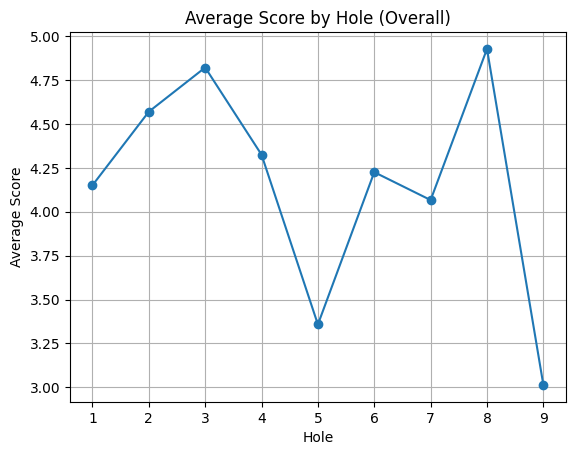

In [ ]:

if "Averages_by_Hole_Overall" in sheets:
    plt.figure()
    x = sheets["Averages_by_Hole_Overall"]["Hole"]
    y = sheets["Averages_by_Hole_Overall"]["AvgScore"]
    plt.plot(x, y, marker="o")
    plt.title("Average Score by Hole (Overall)")
    plt.xlabel("Hole")
    plt.ylabel("Average Score")
    plt.grid(True)
    plt.show()


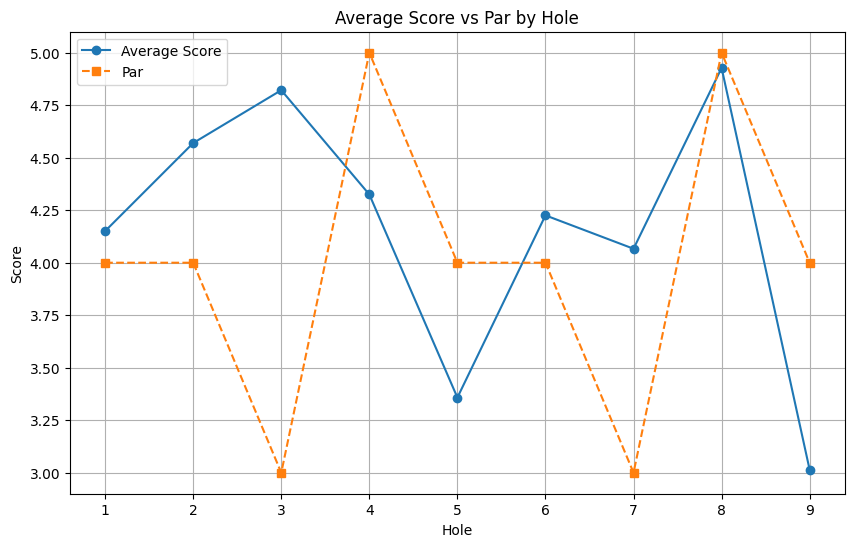

In [ ]:
# Replace with your actual par for 1–18 (or 1–9 if it’s a 9-hole sheet)
par_values18 = [4,4,3,5,4,4,3,5,4, 4,5,3,4,4,5,3,4,4]  # example

# Build a dict {hole_number: par}
par_map = {i+1: par_values18[i] for i in range(len(par_values18))}

# Your existing data
x = sheets["Averages_by_Hole_Overall"]["Hole"]            # e.g., [1..9]
y = sheets["Averages_by_Hole_Overall"]["AvgScore"]

# Align par to the holes present in x (same length as x)
par_line = x.map(par_map)  # works even if x is only 1..9

plt.figure(figsize=(10,6))
plt.plot(x, y, marker="o", label="Average Score")
plt.plot(x, par_line, marker="s", linestyle="--", label="Par")
plt.title("Average Score vs Par by Hole")
plt.xlabel("Hole")
plt.ylabel("Score")
plt.xticks(sorted(x.unique()))
plt.legend()
plt.grid(True)
plt.show()
